In [142]:
import pandas as pd
import numpy as np
from datetime import datetime
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

test_period = [['2023-01-01', '2024-06-01']]

In [143]:
data = pd.read_csv('./merged_df.csv')
data['year-month'] = data['year-month'].apply(lambda x: str(datetime.strptime(x, '%Y-%m'))[:10])
data.set_index(keys=['year-month'], inplace=True)
sub_data = data[data['Monthly EV Sales with Noise'] > 0].copy()
sub_data.head(5)

,gas_value,Monthly EV Sales with Noise,Close,stations_number,Number of Licensed Drivers,electricity_price
year-month,,,,,,
2021-01-01,2.42025,845.419355,54.295263,85615.0,2.327820e+08,0.136
2021-02-01,2.58700,982.357143,57.543684,86786.0,2.328538e+08,0.137
2021-03-01,2.89760,1396.096774,55.610435,88122.0,2.329257e+08,0.138
2021-04-01,2.94775,1178.300000,57.717619,89724.0,2.329975e+08,0.139
2021-05-01,3.07620,1000.290323,48.893000,91551.0,2.330693e+08,0.140


In [144]:
def evaluate(res):
    y_true, y_pred = res
    metrics_dict = {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred)
    }
    return metrics_dict

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[3]             : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[3]             : AIC=281.267, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[3]             : AIC=284.523, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[3]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=283.267, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[3]             : AIC=282.529, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[3]             : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[3] intercept   : AIC=283.260, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[3]          
Total fit time: 0.654 seconds


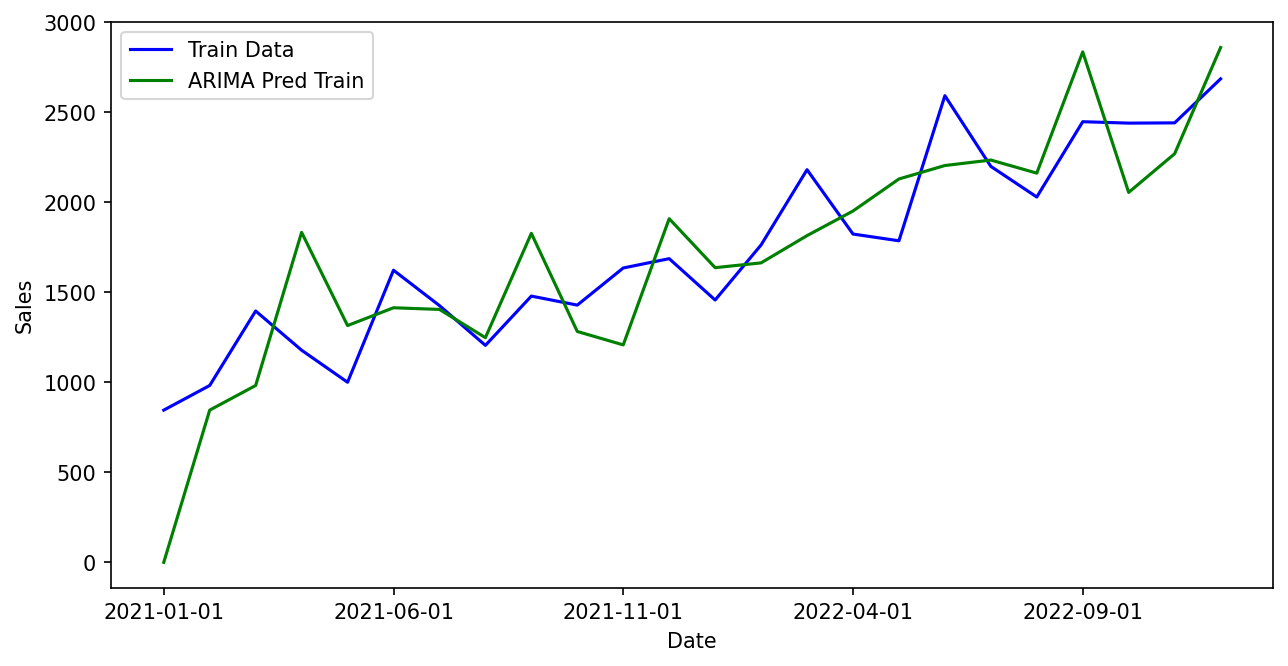

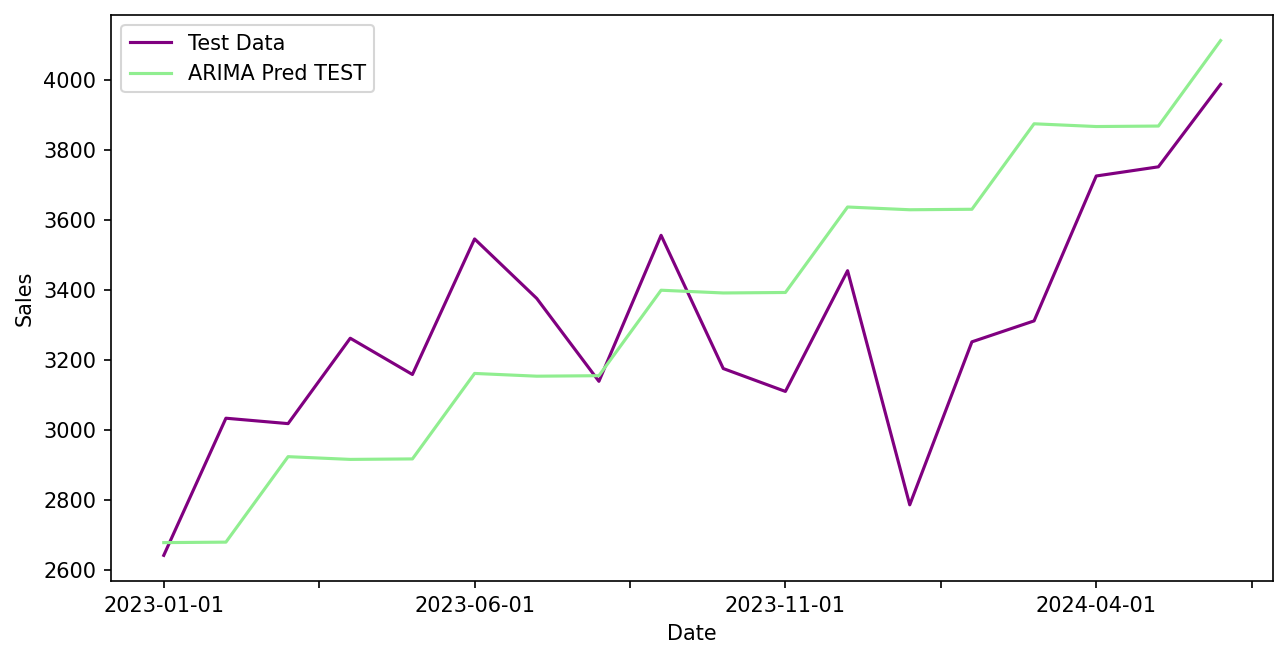

In [158]:
train_index = [index for index in sub_data.index if index < test_period[0][0]]
test_index = [index for index in sub_data.index if index >= test_period[0][0]]
train_data = sub_data.loc[train_index]
test_data = sub_data.loc[test_index]
model = pm.auto_arima(train_data['Monthly EV Sales with Noise'], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         start_P=0, seasonal=True, m=3,
                         d=1, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

plt.figure(figsize=(10, 5), dpi=150)
pred_data = pd.DataFrame(model.fittedvalues(), columns=['ARIMA Pred'])
pred_data_test = pd.DataFrame(model.predict((datetime.strptime(test_period[0][1], '%Y-%m-%d') - datetime.strptime(test_period[0][0], '%Y-%m-%d')).days // 30 + 1), columns=['ARIMA Pred'])
train_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue')
pred_data['ARIMA Pred'].plot(color='green', label='ARIMA Pred Train')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
y_pred, y_true = list(train_data['Monthly EV Sales with Noise']), list(pred_data['ARIMA Pred'])
evaluate([y_pred, y_true])
pred_data_test.index = pd.Index([str(index)[:10] for index in pred_data_test.index])

plt.figure(figsize=(10, 5), dpi=150)

test_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='purple')
pred_data_test['ARIMA Pred'].plot(color='lightgreen', label='ARIMA Pred TEST')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()

In [159]:
columns = sub_data.columns.to_list()
columns.remove('Monthly EV Sales with Noise')
res_data = sub_data[columns]
res_data['Residual'] = train_data['Monthly EV Sales with Noise'] - pred_data['ARIMA Pred']
res_data_train = res_data.loc[train_index]
res_data_test = res_data.loc[test_index]
X_train, y_train = res_data_train[columns], res_data_train['Residual']
X_test, y_test = res_data_test[columns], test_data['Monthly EV Sales with Noise'] - pred_data_test['ARIMA Pred']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=columns)
X_test, y_test

(    gas_value     Close  stations_number  Number of Licensed Drivers  \
 0   -0.209151 -0.924459         2.089553                    2.255370   
 1   -0.121373 -0.421763         2.243212                    2.481213   
 2   -0.068518 -0.620590         2.451850                    2.707057   
 3    0.206717 -0.715351         2.604380                    2.932900   
 4    0.136949 -0.101679         2.775910                    3.158744   
 5    0.165216  0.251968         3.079546                    3.384587   
 6    0.209301  0.591514         3.266928                    3.610431   
 7    0.588052  0.528391         3.491241                    3.836274   
 8    0.593142  0.658630         3.707598                    4.062117   
 9    0.255656  0.444501         3.986415                    4.287961   
 10  -0.213379  1.196274         4.214765                    4.513804   
 11  -0.503883  1.986460         4.402979                    4.739648   
 12  -0.598160  2.129420         4.585434          

In [160]:
def forest(X_train, y_train, pred_data):
    forest = RandomForestRegressor()
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_train)
    forest_data = train_data.copy()
    forest_data['Pred Residual'] = y_pred
    forest_data['RF Pred'] = forest_data['Pred Residual'] + pred_data['ARIMA Pred']
    plt.figure(figsize=(10, 5), dpi=150)
    forest_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=4)
    pred_data['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    forest_data['RF Pred'].plot(color='lightgreen', label='RF Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return forest, X_train, y_train

def forest_test(forest, X_test, y_test, pred_data_test):
    y_pred = forest.predict(X_test)
    forest_data = test_data.copy()
    forest_data['Pred Residual'] = y_pred
    forest_data['RF Pred'] = forest_data['Pred Residual'] + pred_data_test['ARIMA Pred']
    plt.figure(figsize=(10, 5), dpi=150)
    forest_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='blue', linewidth=4)
    pred_data_test['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    forest_data['RF Pred'].plot(color='lightgreen', label='RF Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return X_train, y_train

In [161]:
def xgb(X_train, y_train, pred_data):
    xgb = XGBRegressor()
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_train)
    xgb_data = train_data.copy()
    xgb_data['Pred Residual'] = y_pred
    xgb_data['XGB Pred'] = xgb_data['Pred Residual'] + pred_data['ARIMA Pred']
    plt.figure(figsize=(10, 5), dpi=150)
    xgb_data['Monthly EV Sales with Noise'].plot(label='Train Data', color='blue', linewidth=4)
    pred_data['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    xgb_data['XGB Pred'].plot(color='green', label='XGB Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return xgb, X_train, y_train

def xgb_test(xgb, X_test, y_test, pred_data_test):
    y_pred = xgb.predict(X_test)
    xgb_data = test_data.copy()
    xgb_data['Pred Residual'] = y_pred
    xgb_data['RF Pred'] = xgb_data['Pred Residual'] + pred_data_test['ARIMA Pred']
    plt.figure(figsize=(10, 5), dpi=150)
    xgb_data['Monthly EV Sales with Noise'].plot(label='Test Data', color='blue', linewidth=4)
    pred_data_test['ARIMA Pred'].plot(color='orange', label='ARIMA Pred', linewidth=2)
    xgb_data['RF Pred'].plot(color='lightgreen', label='RF Pred')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    return X_train, y_train

(    gas_value     Close  stations_number  Number of Licensed Drivers  \
 0   -1.814284  1.361847        -1.395547                   -1.204644   
 1   -1.553143  1.652422        -1.326021                   -1.136024   
 2   -1.066725  1.479490        -1.246698                   -1.067403   
 3   -0.988187  1.667980        -1.151582                   -0.998782   
 4   -0.787027  0.878608        -1.043107                   -0.930161   
 5   -0.660881  0.979948        -0.947159                   -0.861541   
 6   -0.545384  0.747613        -0.850024                   -0.792920   
 7   -0.506389  0.230184        -0.738759                   -0.724299   
 8   -0.481175  0.291946        -0.617637                   -0.655678   
 9   -0.304602  0.650239        -0.447354                   -0.587058   
 10  -0.137425  0.410680        -0.304383                   -0.518437   
 11  -0.270540  0.038108        -0.155890                   -0.449816   
 12  -0.259891  0.044744        -0.054064          

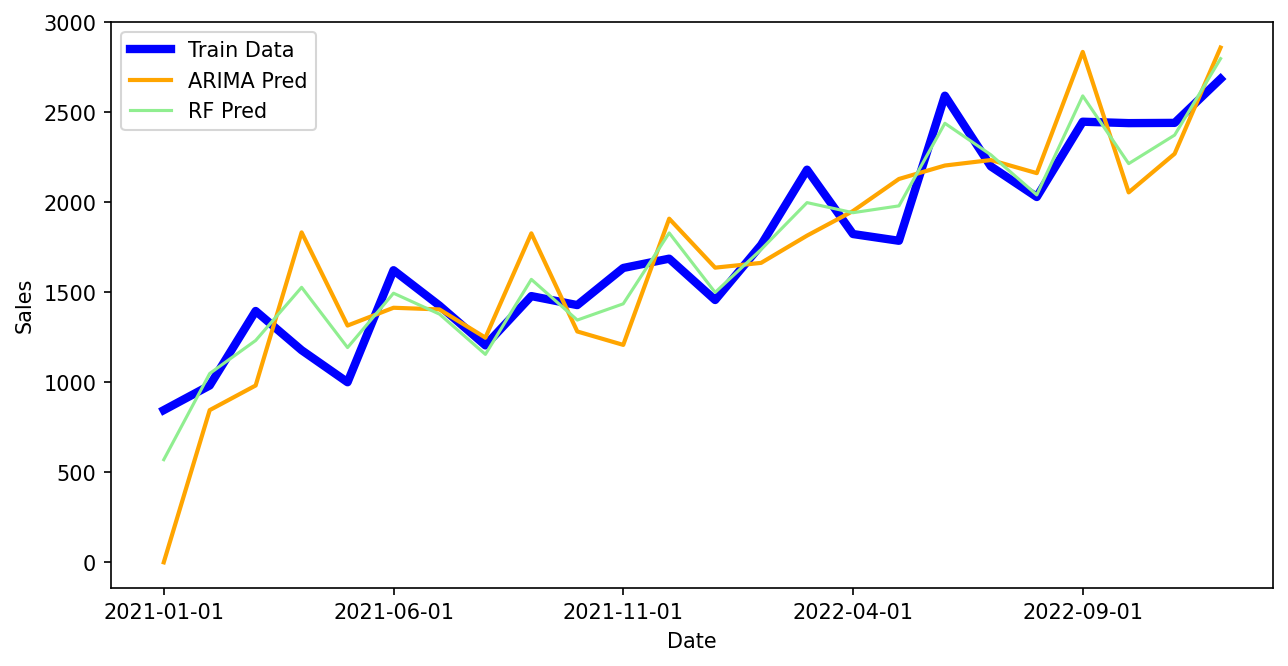

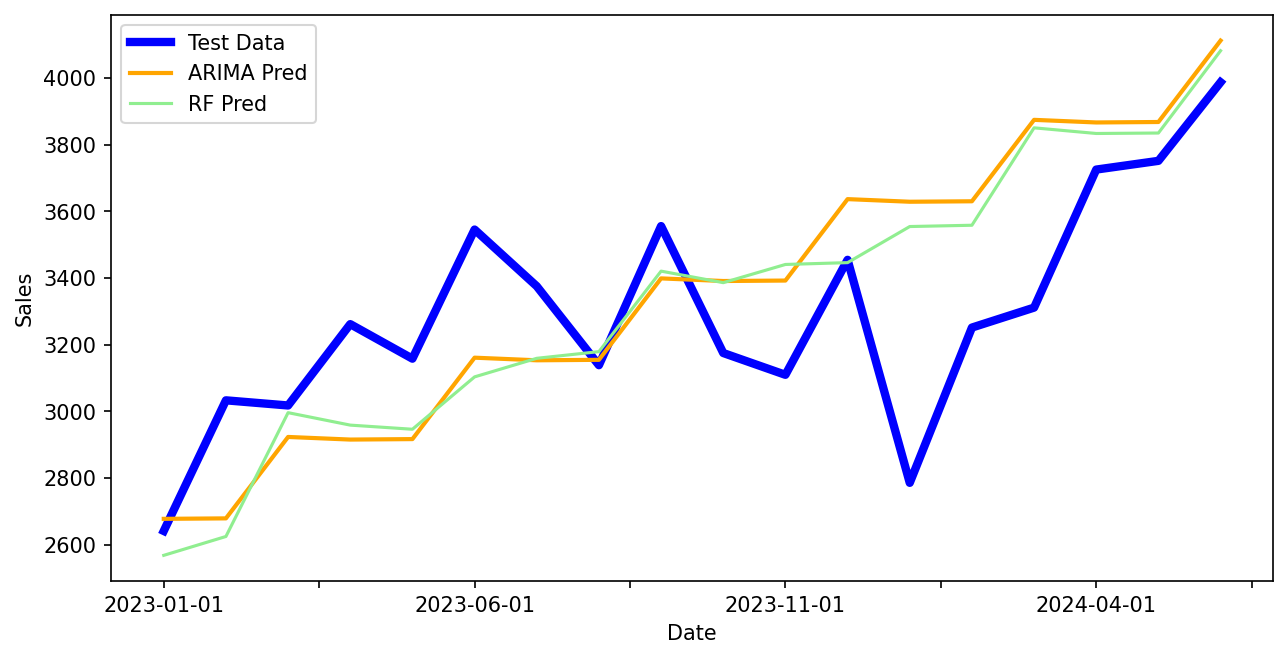

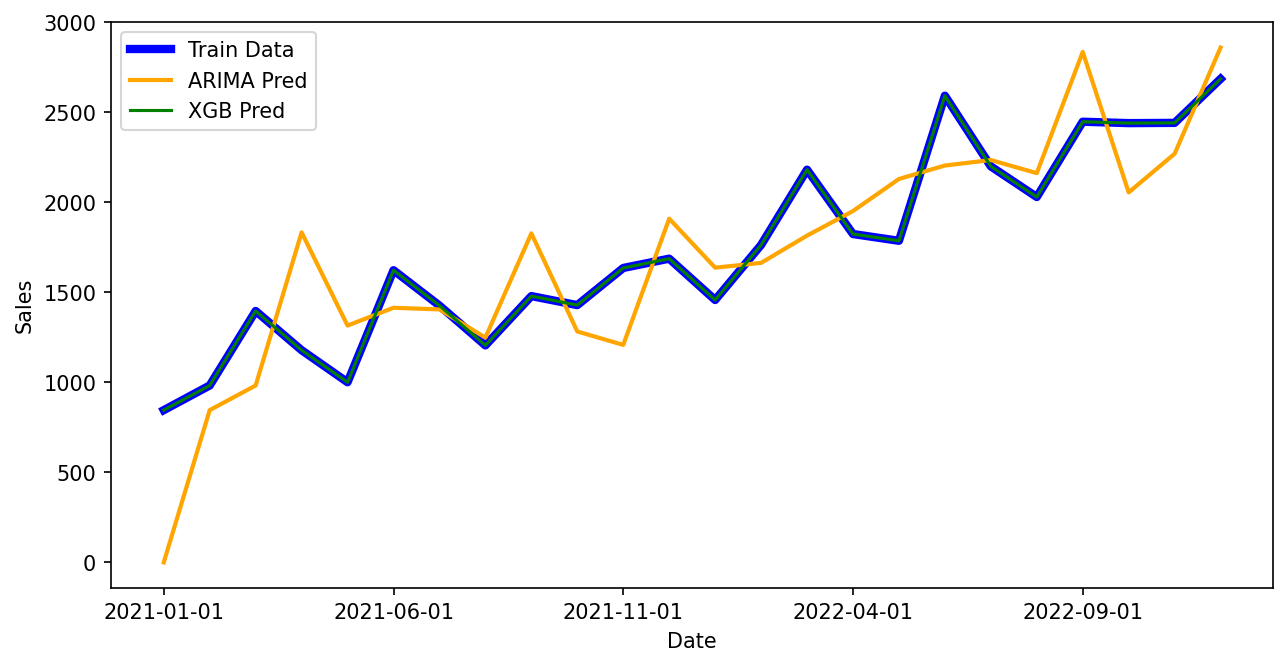

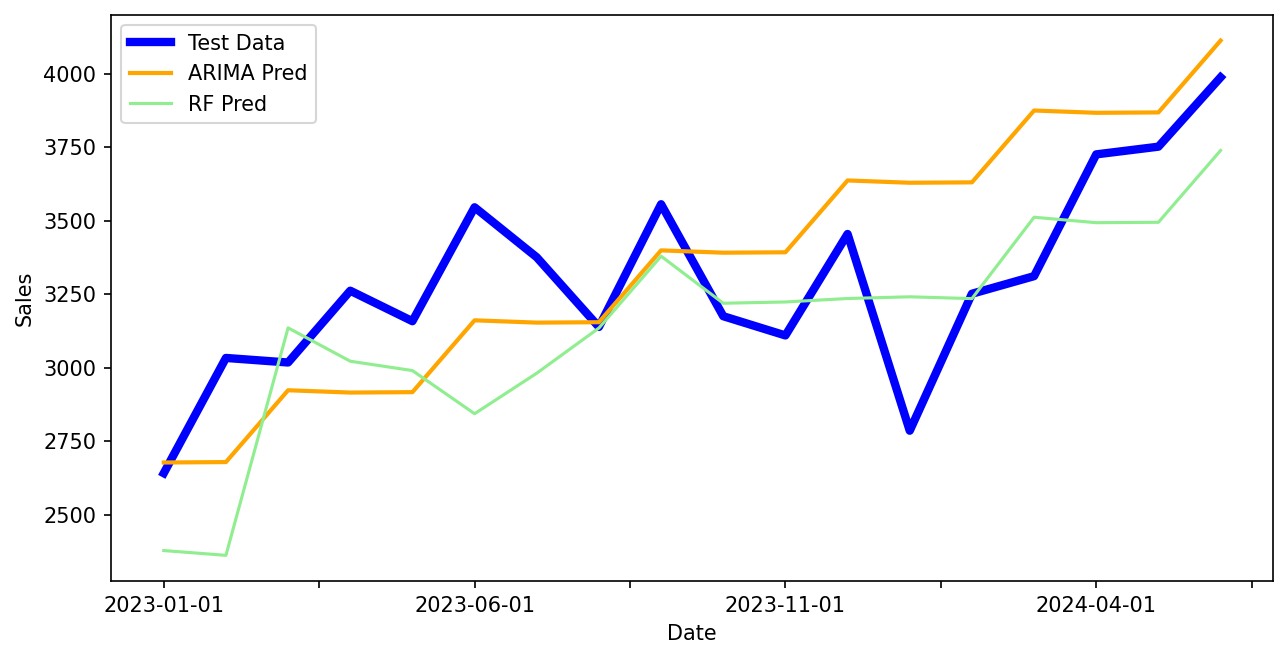

In [162]:
res = forest(X_train, y_train, pred_data)
forest_test(res[0], X_test, y_test, pred_data_test)

res = xgb(X_train, y_train, pred_data)
xgb_test(res[0], X_test, y_test, pred_data_test)